In [28]:
#imports các thư viện
import numpy as np
from math import sqrt
from numpy import concatenate

import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.utils import shuffle
from sklearn.model_selection import KFold

from matplotlib import pyplot
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure

import pandas as pd
from pandas import read_csv
from pandas import DataFrame
from pandas import concat


import keras.utils
from keras.models import Sequential
from keras.models import Model
from keras.layers import Dropout
from keras.layers import Activation
from keras.layers import Bidirectional
from keras.layers import Input, concatenate, Dense
from keras.layers import LSTM, GRU
from keras.optimizers import Adam

import tensorflow as tf
import seaborn as sn
import seed
import os
tf.get_logger().setLevel('ERROR')

In [29]:
def rsi(data, period: int = 14):

    delta = data["Close"].diff()

    up, down = delta.copy(), delta.copy()
    up[up < 0] = 0
    down[down > 0] = 0

    gain = up.ewm(com=(period - 1), min_periods=period).mean()
    loss = down.abs().ewm(com=(period - 1), min_periods=period).mean()

    RS = gain / loss
    return 100 - (100 / (1 + RS))

In [30]:
#lag granularity (độ trễ) - days or hours
lag_granularity = "hours"
#lag value
lag = 1
# type of analyser - TextBlob or vader
analyser = "vader"
# analyser = "TextBlob"
#dataset grouped type - day or hour
dataset_grouped_by = "hour"

In [31]:
#read dataset
folder = "./../../datasets/tweets_prices_volumes_sentiment/" + \
    analyser+"/"+dataset_grouped_by+"_datasets/cleaned"
filename = folder+"/final_data_lag_"+lag_granularity+"_" + \
    str(lag)+".csv" if (lag > 0) else folder+"/final_data_no_lag.csv"
df = pd.read_csv(filename, index_col='DateTime', parse_dates=True)

In [32]:
#group by datetime
df = df.groupby('DateTime').agg(lambda x: x.mean())
df

C:\Users\Windows 10\AppData\Local\Temp\ipykernel_11652\3489936249.py:2: FutureWarning: ['dt'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  df = df.groupby('DateTime').agg(lambda x: x.mean())


,Close,Volume_(BTC),Weighted_Price,neg_pol,neu_pol,pos_pol,compound,Tweet_vol
DateTime,,,,,,,,
2018-08-31 10:00:00+00:00,6949.40,2.333380,6948.996140,0.040167,0.876000,0.083833,0.155633,18.0
2018-08-31 11:00:00+00:00,6946.06,2.430317,6948.538492,0.020167,0.865000,0.114833,0.246883,37.0
2018-08-31 12:00:00+00:00,6963.30,3.922626,6964.052374,0.035800,0.839600,0.124600,0.254660,42.0
2018-08-31 13:00:00+00:00,6900.00,9.040247,6932.162091,0.084000,0.789250,0.126917,0.218183,55.0
2018-08-31 14:00:00+00:00,6927.92,5.947736,6912.448529,0.025333,0.861444,0.113222,0.263544,38.0
...,...,...,...,...,...,...,...,...
2019-11-23 11:00:00+00:00,7180.02,6.622678,7190.277423,0.067410,0.760387,0.172199,0.250681,2304.0
2019-11-23 12:00:00+00:00,7157.47,7.074875,7181.956969,0.072038,0.751780,0.176183,0.235377,2467.0
2019-11-23 13:00:00+00:00,7181.50,9.766378,7171.704462,0.072152,0.756339,0.171514,0.245202,2612.0


In [33]:
#tính toán các chỉ số indicator: rsi, ma
#get change label
df["Change"] = (df["Close"] > df["Close"].shift(1)).astype(int)

add_RSI = True
add_longMAvg = True
add_shortMAvg = True

if(add_RSI):
    #calcualte RSI
    RSI = 14
    df['RSI'] = rsi(df, RSI)
    df = df.iloc[RSI:]

#calculate moving averages
if(add_shortMAvg):
    short_window = 9
    df['short_mavg'] = df.rolling(window=short_window)["Close"].mean()

if(add_longMAvg):
    long_window = 21
    df["long_mavg"] = df.rolling(window=long_window)["Close"].mean()

if(add_longMAvg):
    df = df.iloc[long_window:]
elif(add_RSI):
    df = df.iloc[RSI:]
elif(add_shortMAvg):
    df = df.iloc[short_window:]

C:\Users\Windows 10\AppData\Local\Temp\ipykernel_11652\259356298.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['short_mavg'] = df.rolling(window=short_window)["Close"].mean()
C:\Users\Windows 10\AppData\Local\Temp\ipykernel_11652\259356298.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["long_mavg"] = df.rolling(window=long_window)["Close"].mean()


In [34]:
#keep only wanted columns
features = ['Change', 'subjectivity', 'polarity', 'Tweet_vol', 'Volume_(BTC)'] if analyser == "Textblob" else [
    'Change', 'Close', 'pos_pol', 'neg_pol', 'Tweet_vol']

if(add_RSI):
    features.append("RSI")

if(add_longMAvg):
    features.append("long_mavg")

if(add_shortMAvg):
    features.append("short_mavg")

df = df[features]

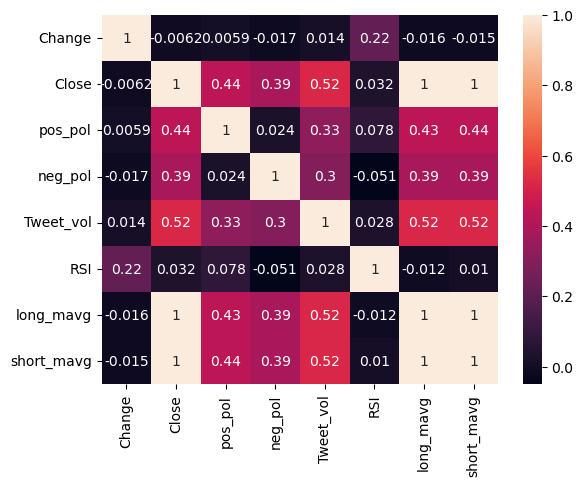

In [35]:
#plot correlation matrix
sn.heatmap(df.corr(), annot=True)
plt.show()


In [36]:
#creating copy so that data is not loaded once again
df_copy = df.copy()

In [37]:
#number of previous records to consider for every example
n_lag = 7
#number of features
n_features = len(features)
#calculate total_features
total_features = n_lag*n_features

if(total_features == 0):
    total_features = n_features

In [38]:
data_with_lagged = df_copy.dropna()
data_with_lagged

,Change,Close,pos_pol,neg_pol,Tweet_vol,RSI,long_mavg,short_mavg
DateTime,,,,,,,,
2018-09-01 21:00:00+00:00,0,7195.95,0.070500,0.019000,30.0,65.930409,7097.183810,7156.526667
2018-09-01 22:00:00+00:00,0,7187.23,0.073000,0.073833,37.0,64.172838,7104.425238,7173.410000
2018-09-01 23:00:00+00:00,1,7189.90,0.152250,0.032000,30.0,64.485028,7111.765714,7188.968889
2018-09-02 00:00:00+00:00,1,7197.50,0.063333,0.040333,31.0,65.408993,7119.059048,7197.981111
2018-09-02 01:00:00+00:00,0,7159.99,0.233667,0.000000,18.0,57.462959,7123.820476,7196.502222
...,...,...,...,...,...,...,...,...
2019-11-23 11:00:00+00:00,1,7180.02,0.172199,0.067410,2304.0,39.929000,7223.752857,7204.497778
2019-11-23 12:00:00+00:00,0,7157.47,0.176183,0.072038,2467.0,38.084247,7225.775238,7190.205556
2019-11-23 13:00:00+00:00,1,7181.50,0.171514,0.072152,2612.0,41.201744,7228.573810,7185.751111


In [39]:
#divide df into train and test
train_ratio = 0.85
data_len = len(data_with_lagged)
train_size = int(data_len*train_ratio)

train = data_with_lagged.iloc[:train_size]
train = train.reset_index()
train = train.drop(['DateTime'], axis=1)

train

,Change,Close,pos_pol,neg_pol,Tweet_vol,RSI,long_mavg,short_mavg
0,0,7195.95,0.070500,0.019000,30.0,65.930409,7097.183810,7156.526667
1,0,7187.23,0.073000,0.073833,37.0,64.172838,7104.425238,7173.410000
2,1,7189.90,0.152250,0.032000,30.0,64.485028,7111.765714,7188.968889
3,1,7197.50,0.063333,0.040333,31.0,65.408993,7119.059048,7197.981111
4,0,7159.99,0.233667,0.000000,18.0,57.462959,7123.820476,7196.502222
...,...,...,...,...,...,...,...,...
9112,0,10168.00,0.178109,0.082320,2790.0,40.532781,10194.198095,10216.297778
9113,0,10153.97,0.185682,0.075785,2765.0,38.801796,10194.863333,10208.506667
9114,1,10168.54,0.170748,0.071725,3092.0,41.591447,10195.836190,10201.170000
9115,0,10159.50,0.174339,0.061375,3405.0,40.362089,10197.285714,10192.781111


In [40]:
#chuẩn hóa
xscaler = MinMaxScaler(feature_range=(0, 1))
train = xscaler.fit_transform(train)
scaler_data = xscaler.transform(data_with_lagged)
# scaler_data = data_with_lagged
print(train.shape, scaler_data.shape)

(9117, 8) (10727, 8)


In [41]:
X_train = []
y_train = []

for i in range(n_lag, len(train)):
  X_train.append(train[i-n_lag:i, :])
  y_train.append(train[i, :])

X_train = np.asarray(X_train)
y_train = np.asarray(y_train)

print(X_train.shape, y_train.shape)

(9110, 7, 8) (9110, 8)


In [42]:

# design network
neurons = 64
epochs = 32
dropout = 0.25
batch_size = 80
activ_func = "relu"


In [43]:
# early stopping callback
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience =20)

In [44]:
# Số fold
k = 5
kf = KFold(n_splits=k, shuffle=False)

# List để lưu kết quả dự đoán từ LSTM và GRU
lstm_predictions = []
gru_predictions = []

# Xây dựng mô hình stacking
for train_index, test_index in kf.split(X_train):
    X_sub_train, X_sub_test = X_train[train_index], X_train[test_index]
    y_sub_train, y_sub_test = y_train[train_index], y_train[test_index]
    # Xây dựng mô hình LSTM và huấn luyện
    lstm_model = Sequential()
    lstm_model.add(LSTM(neurons, return_sequences=True, input_shape=(
        X_train.shape[1], X_train.shape[2]), activation=activ_func))
    lstm_model.add(LSTM(neurons, return_sequences=False))
    lstm_model.add(Dense(8))
    lstm_model.compile(optimizer='adam', loss='mean_squared_error')

    # Xây dựng mô hình GRU và huấn luyện
    gru_model = Sequential()
    gru_model.add(GRU(neurons, return_sequences=True, input_shape=(
        X_train.shape[1], X_train.shape[2]), activation=activ_func))
    gru_model.add(GRU(neurons, return_sequences=False))
    gru_model.add(Dense(8))
    gru_model.compile(optimizer='adam', loss='mean_squared_error')
    
    lstm_model.fit(X_sub_train, y_sub_train, epochs=epochs, batch_size=batch_size)

    gru_model.fit(X_sub_train, y_sub_train, epochs=epochs, batch_size=batch_size,)

    # Lấy đầu ra của mô hình LSTM và GRU
    lstm_output = lstm_model.predict(X_sub_test)
    gru_output = gru_model.predict(X_sub_test)
    
    lstm_predictions.append(lstm_output)
    gru_predictions.append(gru_output)

Epoch 1/32
92/92 [==============================] - 4s 9ms/step - loss: 0.0526
Epoch 2/32
92/92 [==============================] - 1s 8ms/step - loss: 0.0347
Epoch 3/32
92/92 [==============================] - 1s 8ms/step - loss: 0.0342
Epoch 4/32
92/92 [==============================] - 1s 9ms/step - loss: 0.0340
Epoch 5/32
92/92 [==============================] - 1s 8ms/step - loss: 0.0340
Epoch 6/32
92/92 [==============================] - 1s 8ms/step - loss: 0.0337
Epoch 7/32
92/92 [==============================] - 1s 8ms/step - loss: 0.0338
Epoch 8/32
92/92 [==============================] - 1s 8ms/step - loss: 0.0337
Epoch 9/32
92/92 [==============================] - 1s 9ms/step - loss: 0.0335
Epoch 10/32
92/92 [==============================] - 1s 8ms/step - loss: 0.0335
Epoch 11/32
92/92 [==============================] - 1s 8ms/step - loss: 0.0336
Epoch 12/32
92/92 [==============================] - 1s 8ms/step - loss: 0.0334
Epoch 13/32
92/92 [==============================

In [45]:
type(lstm_predictions)

list

In [46]:
# Lấy đầu ra của LSTM và GRU
lstm_outputs = np.concatenate(lstm_predictions, axis=0)
gru_outputs = np.concatenate(gru_predictions, axis=0)


In [47]:
from numpy import column_stack

lstm_outputs = xscaler.inverse_transform(lstm_outputs)
gru_outputs = xscaler.inverse_transform(gru_outputs)

y_train = xscaler.inverse_transform(y_train)

stacking_inputs = column_stack((lstm_outputs, gru_outputs))

In [48]:
print(stacking_inputs[:, 1], y_train[:, 1])

[ 7185.8403  7245.3066  7327.162  ... 10303.725  10284.713  10286.733 ] [ 7183.12  7208.98  7230.99 ... 10168.54 10159.5  10208.42]


In [49]:
stacking_model = Sequential()
stacking_model.add(Dense(16, input_shape=(stacking_inputs.shape[1],)))
stacking_model.add(Dense(8, activation='linear'))
stacking_model.compile(optimizer='adam', loss='mean_squared_error')

# Train stacking model
stacking_model.fit(stacking_inputs, y_train, epochs=50, batch_size=batch_size, verbose=1)

Epoch 1/50


114/114 [==============================] - 1s 1ms/step - loss: 20734454.0000
Epoch 2/50
114/114 [==============================] - 0s 1ms/step - loss: 965390.1250
Epoch 3/50
114/114 [==============================] - 0s 1ms/step - loss: 739406.1250
Epoch 4/50
114/114 [==============================] - 0s 1ms/step - loss: 697455.6875
Epoch 5/50
114/114 [==============================] - 0s 1ms/step - loss: 675693.8125
Epoch 6/50
114/114 [==============================] - 0s 1ms/step - loss: 658634.1250
Epoch 7/50
114/114 [==============================] - 0s 1ms/step - loss: 650919.0000
Epoch 8/50
114/114 [==============================] - 0s 1ms/step - loss: 647257.6875
Epoch 9/50
114/114 [==============================] - 0s 1ms/step - loss: 640670.1250
Epoch 10/50
114/114 [==============================] - 0s 1ms/step - loss: 635394.4375
Epoch 11/50
114/114 [==============================] - 0s 1ms/step - loss: 632908.5000
Epoch 12/50
114/114 [==============================] - 0s 1ms

In [50]:
#tạo testing data set
test_data = scaler_data[train_size - n_lag: , :]
x_test = []
y_test = data_with_lagged[train_size:]

for i in range(n_lag, len(test_data)):
  x_test.append(test_data[i-n_lag:i, :])

x_test = np.asarray(x_test)
print(x_test.shape, y_test.shape)

(1610, 7, 8) (1610, 8)


In [51]:
#get the models predicted price value
lstm_test_predictions = lstm_model.predict(x_test)
gru_test_predictions = gru_model.predict(x_test)

lstm_test_predictions = xscaler.inverse_transform(lstm_test_predictions)
gru_test_predictions = xscaler.inverse_transform(gru_test_predictions)

stacking_close_predictions = stacking_model.predict(column_stack((lstm_test_predictions, gru_test_predictions)))

# stacking_close_predictions = xscaler.inverse_transform(stacking_close_predictions)

stacking_close_predictions.shape

 1/51 [..............................] - ETA: 1s

51/51 [==============================] - 0s 1ms/step


(1610, 8)

In [52]:
#sai số
mse = (((y_test - stacking_close_predictions)**2).mean())
mae = np.abs((y_test - stacking_close_predictions).mean())
mape = np.mean(np.abs((y_test - stacking_close_predictions) / y_test)) * 100
smape = (100 / len(y_test)) * np.sum(2 * np.abs(stacking_close_predictions - y_test) / (np.abs(stacking_close_predictions) + np.abs(y_test)))
print(mse["Close"], mae["Close"], mape["Close"], smape["Close"])


15059.492712056952 57.326386548913035 0.9768690975411021 0.9740597884037868


c:\Users\Windows 10\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3462: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


C:\Users\Windows 10\AppData\Local\Temp\ipykernel_11652\653746799.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = stacking_close_predictions[:, 1]
C:\Users\Windows 10\AppData\Local\Temp\ipykernel_11652\653746799.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['LSTM'] = lstm_test_predictions[:, 1]
C:\Users\Windows 10\AppData\Local\Temp\ipykernel_11652\653746799.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[

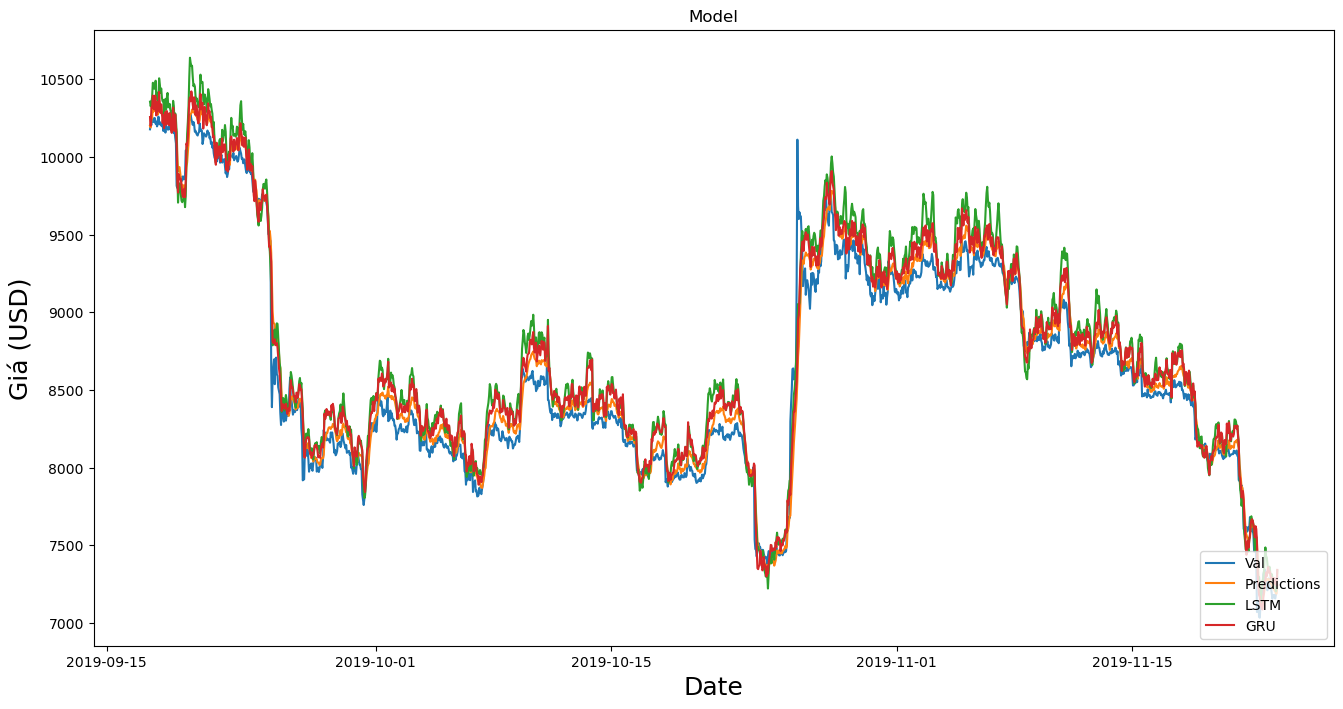

In [53]:
#
valid = data_with_lagged[train_size:]
valid['Predictions'] = stacking_close_predictions[:, 1]
valid['LSTM'] = lstm_test_predictions[:, 1]
valid['GRU'] = gru_test_predictions[:, 1]

#hiển thị dữ liệu gần đây
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Giá (USD)', fontsize=18)
plt.plot(valid[['Close','Predictions','LSTM', 'GRU']])
plt.legend(['Val', 'Predictions', 'LSTM', 'GRU'], loc='lower right')
plt.show()

In [54]:
#create file if it does not exist
data = {
    'Model': 'SE',
    'Thông tin': ['MAE', 'MSE', 'MAPE', 'sMAPE'],
    'Price + Twitter': [mae["Close"], mse["Close"], mape["Close"], smape["Close"]]
}
result_table = pd.read_csv("result-hours.csv")
result_table['Price + Twitter'] = [mae["Close"], mse["Close"], mape["Close"], smape["Close"]]
result_table.to_csv("result-hours.csv", index=False)
result_table

,Model,Thông tin,Price,Price + Twitter
0,SE,MAE,46.741163,57.326387
1,SE,MSE,14537.286524,15059.492712
2,SE,MAPE,0.983028,0.976869
3,SE,sMAPE,0.988685,0.974060
